In [1]:
import matplotlib.pyplot as plt

In [2]:
import addSrcToPath
import numpy as np
import os
import random
import torch
import time
from model.yolov8.semantic import Model
from dataloader import DataProvider
import cv2
from utils.tensor import tile, untile
from utils.image import resizeAndPad as padImage
random.seed(time.time())

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# annotationsDir = os.path.join('.', 'data', 'coco', 'val2017')
# trainDataloader = DataProvider(annotationsDir, 1)

# model = torch.load('./Yolov8_bz4_Epochs1_randxy_n-5_dl-50_center_color_epochs-9.pt')
model = torch.load('./outputs/Yolov8_bz4_Epochs1_randxy_n-5_dl-50_centerColor_d-cocoTest/epochs-0.pt')
model.eval()

print(next(model.parameters()).is_cuda, next(model.parameters()).is_cuda)



True True


In [3]:
def tilablePadding(image, sx, sy):
    px = image.shape[0]%sx
    py = image.shape[1]%sy
    image = cv2.copyMakeBorder(image, 0, px, 0, py, cv2.BORDER_CONSTANT, value=(114, 114, 114))
    return image
    

In [4]:
image = cv2.imread('./test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = tilablePadding(image, 256, 256)
purple = [98, 68, 158]

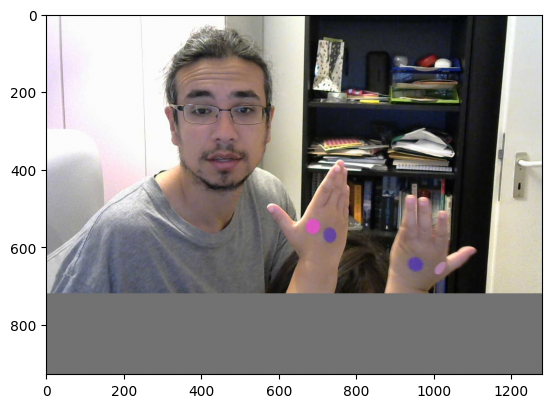

In [5]:

plt.imshow(image/255)

In [11]:
def tile(tensor, sx = 256, sy = 256):
  dx, dy, _ = tensor.shape
  ntx = dx//sx
  nty = dy//sy
  print('ntx, nty',ntx, nty)
  tiles = []
  for i in range(ntx):
    for j in range(nty):
        tiles.append(tensor[i*sx:(i+1)*sx, j*sy:(j+1)*sy])
  
  return torch.stack(tiles), [ntx, nty, sx, sy]

def untile(tensor, tilingInfo):
    ntx, nty, sx, sy = tilingInfo
    c = 1
    if len(tensor.shape) == 4:
        c = tensor.shape[3]

    untiled = torch.zeros([sx*ntx, sy*nty, c])
    untiled = untiled.squeeze(2)
    print('untiled.shape',untiled.shape)
    for i in range(ntx):
        for j in range(nty):
            untiled[i*sx:(i+1)*sx, j*sy:(j+1)*sy] = tensor[i*nty + j]
    return untiled


# npImage = torch.from_numpy(padImage(image))            
# imageTiled, tilingInfo = tile(npImage)
# imageTiled.shape


# imageUntiled = untile(imageTiled, tilingInfo)
# plt.figure(figsize=(100,10))
# plt.imshow(imageUntiled.numpy()/255)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([928, 1280, 3])
ntx, nty 3 5
inputStacked torch.Size([15, 256, 256, 3])
torch.Size([15, 3, 256, 256])
pred: torch.Size([15, 256, 256])
untiled.shape torch.Size([768, 1280])
pred.shape torch.Size([768, 1280])


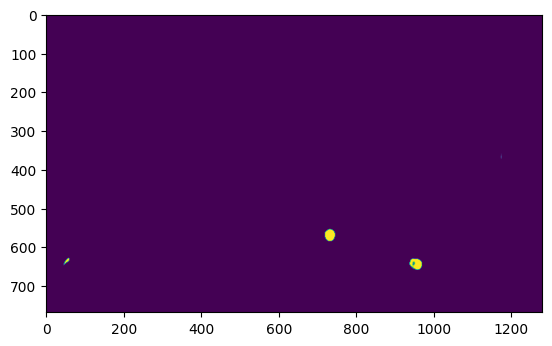

In [12]:
with torch.no_grad():

  xn = image - purple
  x = torch.from_numpy(xn).to(device, dtype=torch.float)
  x = torch.abs(x)/255

  print(x.shape)

  inputStacked, tilingInfo = tile(x)

  print('inputStacked', inputStacked.shape)
  input = inputStacked.permute(0, 3, 1, 2)

  print(input.shape)
  pred = model(input)
  pred = torch.squeeze(pred)
  pred = torch.sigmoid(pred)
  print('pred:', pred.shape)
  pred = untile(pred, tilingInfo)
  print('pred.shape', pred.shape)
  pred = pred.cpu().numpy()

  plt.imshow(xn)
  plt.imshow(pred)

#   cv2.imshow('input', xn/255)
#   cv2.waitKey(0) # waits until a key is pressed
#   cv2.destroyAllWindows() # destroys the window

#   # cv2.imshow('target', y.numpy()[0])
#   # cv2.waitKey(0) # waits until a key is pressed
#   # cv2.destroyAllWindows() # destroys the window

#   cv2.imshow('prediction', pred)
#   cv2.waitKey(0) # waits until a key is pressed
#   cv2.destroyAllWindows() # destroys the window showing image

      # pred = pred.permute(0, 2, 3, 1)
      # cv2.imshow('pred', pred[0])

In [9]:
imageUntiled = untile(inputStacked, ntx, nty)
print(imageUntiled.shape)
plt.imshow(imageUntiled)

NameError: name 'ntx' is not defined

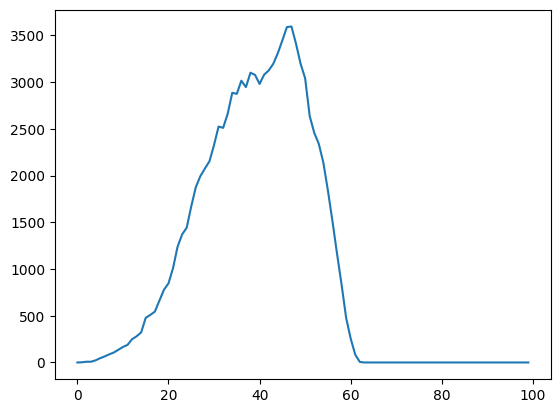

In [37]:
data = [0, 2, 8, 8, 23, 46, 65, 87, 107, 136, 166, 188, 249, 280, 322, 478, 509, 544, 661, 778, 847, 1010, 1240, 1371, 1442, 1671, 1877, 1994, 2076, 2154, 2328, 2525, 2511, 2662, 2886, 2875, 3016, 2947, 3101, 3078, 2981, 3080, 3125, 3196, 3309, 3447, 3589, 3596, 3411, 3198, 3042, 2639, 2458, 2340, 2140, 1841, 1513, 1166, 835, 479, 257, 84, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
plt.plot(data)

In [38]:
t = 0
for d in data:
    t += d
t

100000

In [20]:
def elipsesIntersect(e1, e2):
  dx = (e1[0]-e2[0])**2
  dy = (e1[1]-e2[1])**2
  d = (dx + dy)**0.5
  
  e1r = max(e1[2:])
  e2r = max(e2[2:])

  return d < e1r + e2r

def intersectsPreviousElipses(prevElipses, newElipses, i = 0):
  intersects = False
  i = 0
  while not intersects and len(prevElipses) > i:
    intersects = elipsesIntersect(prevElipses[i], newElipses)
    print('intersects: =>', intersects)
    i += 1

  return intersects

In [22]:
for i, pe in enumerate(prevElipses):
    print('=>', i)
    intersectsPreviousElipses(prevElipses, pe)

=> 0
intersects: => True
=> 1
intersects: => False
intersects: => True
=> 2
intersects: => False
intersects: => False
intersects: => True
=> 3
intersects: => False
intersects: => False
intersects: => False
intersects: => True
=> 4
intersects: => False
intersects: => False
intersects: => False
intersects: => False
intersects: => True


In [61]:
def intersectionBboxes(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1]);
    xB = min(boxA[2], boxB[2]);
    yB = min(boxA[3], boxB[3]);
    print(xA, yA, xB, yB)
    print(((xB - xA)**2 + (yB - yA)**2)**0.5)

    return max(0, xB - xA) * max(0, - yB + yA);

intersectionBboxes([0, 0, 1, 1], [0.1, 1, 0, -0.5])

0.1 1 0 -0.5
1.5033296378372907


0.0

In [96]:
import math
def elipsesIntersect(e1, e2):
  dx = (e1[0]-e2[0])**2
  dy = (e1[1]-e2[1])**2
  d = math.sqrt(dx + dy)
  
  e1r = e1[2]
  e2r = e2[2]

  return d < e1r + e2r

def intersectsPreviousElipses(prevElipses, newElipses, i = 0):
    arrLen = prevElipses
    intersects = False
    i = 0
    
    print(not intersects and len(prevElipses) > i, not intersects, len(prevElipses) > i, len(prevElipses), i )

    while not intersects and len(prevElipses) > i:
        print('intersects, i', intersects, i)
        intersects = elipsesIntersect(prevElipses[i], newElipses)
        print('intersects =>', intersects)
        i += 1

    return intersects

elipses = [
    [6.934106342079374, 34.75108329705357, .83008775369311],
    [4.24944868301317, 36.520124608543966, 3.4754520069906145],
    [34.21487139968251, 33.88358164557086, 15.84079204650926]
]

intersectsPreviousElipses(elipses[0:], elipses[2])
# intersectsPreviousElipses([], elipses[2])

True True True 3 0
intersects, i False 0
intersects => False
intersects, i False 1
intersects => False
intersects, i False 2
intersects => True


True